In [65]:
import sys
import pdb
# sys.path.insert allows us to define paths from where we can import .py files
#sys.path.insert(0, 'D://Users//jvdputte//Documents//Work//Educational//5LSM0//jupyter_scripts//assets')
sys.path.insert(0, 'C://Users//s141010//Documents//school//master//CNN//assets')

import mnist
import numpy as np

## Data loading
First we will load the data from the Mnist data set using the provided *mnist.py* script. To make it a bit easier, we will only use the digits 1, 4, and 6.

In [66]:
#mnist.init() # you only have to run this once, downloads and pickles the data set
x_train, y_train, x_test, y_test = mnist.load()

# only obtain 1, 4, and 6 samples
# for all the labels in the training set, check if the label belongs to the set [1, 4, 6]. 
# list comprehensions automatically constructs a new list from the original
idx146_train = [label in [1, 4, 6] for label in y_train] 
y_train = y_train[idx146_train]
x_train = x_train[idx146_train]

# Same for the test set
idx146_test = [label in [1,4,6] for label in y_test]
y_test = y_test[idx146_test]
x_test = x_test[idx146_test]


In [67]:
print('Shape of training data: {}, Shape of training labels: {}'.format(x_train.shape, y_train.shape))
print('Mean value of training data: {:.3f}, Standard deviation of training data: {:.3f}'
      .format(x_train.mean(), x_train.std()))

Shape of training data: (18502, 784), Shape of training labels: (18502,)
Mean value of training data: 28.033, Standard deviation of training data: 73.068


If we look at the shape of the training data, we can see that the data is stored in vectorized form (The 28x28 pixel images are reshaped to a 1x784 array before storing). From the original 60.000 samples, we only took the 1, 4, and 6 digits so we expect approximately 18.000 samples. The resulting shapes of the training data and training labels is what we expect. Performing sanity checks such as this is generally a good idea, it reduces the amount spent debugging when an inevitable bug shows up.

### Q1: Think of two other sanity checks you could perform (what expectations do we have about our data). Data can be ordinary images but also auxilary information such as for example the age of a patient with accompanying CT scan.

<span style="color:red">''' We can see that there is a label input for each datapoint because x_train and y_train are both 18502. If we know what the data represents the mean value can be predicited, for example if it is the age of a patient it would be expected to be between 30-50. The same holds for the standart deviation, if the data is age we expect ages between 0 and 100 and thus a standart deviation around the 50/3=17 years.'''</span>.

## Standardizing data
Data standardization is an important pre-processing step for nearly all machine learning algorithms. We want to make sure all data is on the same scale.
For example, results may vary drastically if some of the images have values in the range of [0, 1] (double) while others have values in the range of [0, 255] (uint8).

The sklearn library has a variety of tools to make data pre-processing a lot easier, one of which is the StandardScaler class.

In [68]:
from sklearn.preprocessing import StandardScaler

# Create instance of the StandardScaler class
sc = StandardScaler()
# Fit the scaling parameters and transform the training data based on the training set
x_train_scaled = sc.fit_transform(x_train.astype(float))
# transform the test data based on train scaling parameters
x_test_scaled = sc.transform(x_test.astype(float))
print('Mean value of train data: {:.3f}, Standard deviation of train data: {:.3f}'
      .format(x_train.mean(), x_train.std()))
print('Mean value of train data after scaling: {:.3f}, Standard deviation of train data after scaling: {:.3f}'
      .format(x_train_scaled.mean(), x_train_scaled.std()))

Mean value of train data: 28.033, Standard deviation of train data: 73.068
Mean value of train data after scaling: 0.000, Standard deviation of train data after scaling: 0.922


As we can see, the values of the training data is transformed to have mean 0 and a std of approximately 1. With the StandardScaler class, the mean and standard deviation are calculated with the training data. Afterwards, the test set is scaled with the same mean and standard deviation. A common mistake is to calculate seperate means and standard deviations for the train and test set. Lets consider the following example:

The standard score of a sample x is calculated as:

z = (x - $\mu$) / $\sigma$

where $\mu$ is the mean of the training samples, and $\sigma$ is the standard deviation of the training samples

Let's assume we have a simple training set consisting of 3 samples with 1 feature (let's call this feature "length"):

* train_1: 10 cm -> class_2
* train_2: 20 cm -> class_2
* train_3: 30 cm -> class_1

mean: 20, std.: 8.2

After standardization, the transformed feature values are

* train_std_1: -1.21 -> class_2
* train_std_2: 0 -> class_2
* train_std_3: 1.21 -> class_1

Next, let's assume our model has learned to classify samples with a standardized length value < 0.6 as class_2 (class_1 otherwise). So far so good. Now, let's say we have 3 unlabeled data points that we want to classify:

* new_4: 5 cm -> class ?
* new_5: 6 cm -> class ?
* new_6: 7 cm -> class ?

### Q2: Calculate the standardized "length" values of the new samples using the training set parameters as well as with the new test set parameters. How does this affect the resulting predictions on the new samples.

<span style="color:red">''' the code bellow shows that all the points are in class two because they a standirzed length smaller than 0.6. The standrized length has been calulated by takening the orignal lenght, subtracting the mean of the training data and deviding that by the standard deviation of the training data''' </span>.



In [69]:
new_std=[] #initialize the list of the new standrized values
mean=20 #the mean of the train data
std=8.2 #the standard deviation of the train data
for point in [5,6,7]: # loop over the lenghts of the test data
    z=(point-mean)/std #calculate the new standarized values
    new_std.append(z) #save them in a list
classz=np.where([n_std<0.6 for n_std in new_std],2,1) #check for each entry if it is in class one or two depending on if it is higher or lower than 0.6
print(new_std) #print the standarized values
print(classz) #print the classes



[-1.829268292682927, -1.707317073170732, -1.5853658536585367]
[2 2 2]


## K-nearest neighbors
Finding clusters in data is an important topic in image analysis, machine learning and pattern recognition. Points in a cluster are similar and share certain properties. Hence, knowing the boundaries of these clusters is very useful for making a prediction about the properties of a new – unseen –  data point. An example from image processing is finding the distinction between background and foreground in a video frame. Using region properties of annotated images you can find clusters for both, which you can use to predict the back- and foreground in a new frame. Another, widely studied, example is the clustering/classification of handwritten digits. In this exercise you will implement the **K-nearest neigbors** algorithm to cluster handwritten digits. This will illustrate the power of these algorithms to find clusters in data. The use of handwritten digits allows us to visually check the clustering result of high-dimensional data in a meaningful way. Furthermore, you will see that by using **Principal Component Analysis (PCA)**, you can reduce the dimensionality significantly, while still retaining enough information to find relevant clusters.

### Q3.	Cluster the data with your own implementation of the K-nearest neighbors clustering algorithm. Do this using K=1. Calculate the accuracy of your algorithm.

Note: the algorithm could take quite a while since you would have to compare every test sample to every training sample depending on your cpu. Check to see if the algorithm works on a few samples before you use the entire set. For reference, on my laptop it took approximately 5 minutes.

In [70]:
labels=[]
N=30 #amount of pictures tested
x_test_new=x_test_scaled[1:N]
for test in x_test_new:
    diff=[] #clear the diff vector for each new test data entry
    for train in x_train_scaled: 
        diff.append(np.linalg.norm(test-train)) #calculate the euclidean distance between the test and train data and save in a list
    labelposition=np.argmin(diff) #get the position of the lowest difference
    labels.append(y_train[labelposition]) #get the label of the train data that is closetst to the test data

#accuracy
error=np.where(labels == y_test[1:N], 0, 1)
accurcacy= (len(x_test_new) -sum(error))/ len(x_test_new)    

print('the accuaracy is {:.3f}' .format(accurcacy))

the accuaracy is 1.000


Great! The accuracy on the test set is already very high (should be 96%+). However, this problem is not very complex and the image size is relatively small (28x28). In complex real-world problems, the performance of this algorithm will plummet. 

### Q4. Give two reasons why knn on direct pixel values not a good choice for most real-world problems. Hint 1: Try running your 1-nn algorithm with more digits. What do you observe? Hint 2: Curse of dimensionality.

<span style="color:red">''' When you run the diffrence on a pixel level things like changing the lighting or shifting the picture a pixel tot the side, will have a big influence and might not be seen as being in the same class. Futermore everytime you want to classifie a picture you need to compair it to all the training picures. This will take a lot of computations (the amount of pixels in the pictures times the size of the training set) '''</span>.

## Principle Component Analysis
In order to overcome the unscalability of training classifyers on pixel values directly, dimensionality reduction is neccesary. Principle component analysis (PCA) is an unsupervised dimensionality reduction technique which we will implement in this assignment. The original feature vector (784 dimensions) will be reduced to *k* dimensions.

PCA is implemented in the following steps:

* Construct the covariance matrix.
* Decompose the covariance matrix into its eigenvectors and eigenvalues.
* Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors.
* Select the *k* eigenvectors which correspond to the *k* largest eigenvalues, where *k* is the dimensionality of the new feature subspace.
* Construct a projection matrix **W** from the "top" *k* eigenvectors.
* Transform the d-dimensional input data set using **W** to obtain a new k-dimensional feature subspace

### Q5a. calculate the eigendecomposition of the covariance matrix. Hint: use np.cov() and np.linalg.eigh()

In [71]:
# Calculate eigenvalues and eigenvectors here
covariance=np.cov(x_train_scaled.transpose())
value,vector=np.linalg.eigh(covariance)
sorted_value=sorted(value, reverse=True) #sort the eigen values from heigh to low

### Q5b. Calculate the cumulative and explained variance. Remember: the eigenvalues have to be sorted in decreasing order.

In [72]:
# calculate total and explained variance here. If you name the variables cum_var_exp and var_exp the plotting function
# in the next cell will work nicely

var_exp=sorted_value/sum(sorted_value)
cum_var_exp=np.cumsum(var_exp)


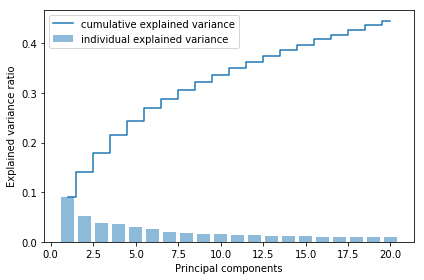

In [73]:
import matplotlib.pyplot as plt
# This function will plit the first num_features in order of importance. 

num_features = 20

plt.bar(range(1, num_features+1), var_exp[:num_features], alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(1, num_features+1), cum_var_exp[:num_features], where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('./figures/pca1.png', dpi=300)
plt.show()

### Q5c. Construct **W** with *k=2* (the first two features with most explained variance). Hint: **W** should have shape (784,2)

In [74]:
# Construct W here, the next cell will plot the clusters for you based on the first two principle components
k=2
#the eigenvector matrix is sorted from lowest to highest, so to get the highste two the last entries will be used
W1=vector[:,-k]
W2=vector[:,-1]
W=np.c_[W2,W1]
W.transpose()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

The following cell calculates the new training features and plots them to show the clustered samples. If PCA was implemented correctly you can clearly see a clustering in the new feature space. The clustering is not perfect but we reduced the dimensionality of our feature space drastically

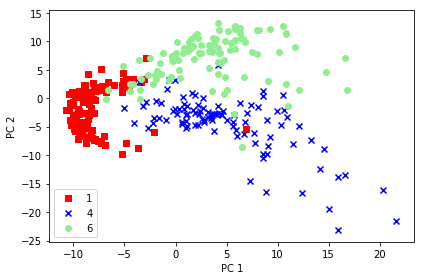

In [75]:
from matplotlib.colors import ListedColormap

x_train_pca = x_train_scaled.dot(W)
markers = ('s', 'x', 'o', '^', 'v')
colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
labels = (1, 4, 6)
cmap = ListedColormap(colors[:len(np.unique(y_train))])

for label, c, m in zip(labels, colors, markers):
    plt.scatter(x_train_pca[y_train == label, 0][:100], 
                x_train_pca[y_train == label, 1][:100], 
                c=c, label=label, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca2.png', dpi=300)
plt.show()

## PCA in sklearn
While implementing your own algorithms is good excercise, most commonly used algorithms have already been efficiently implemented. Both PCA and KNN have been implemented in the sklearn library. Look through the code below make sure you understands how the sklearn functions are used.

In [76]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25) # instantiate an instance of the PCA class with 25 components
x_train_pca = pca.fit_transform(x_train_scaled) # the fit_transform function operates the same way as in the StandardScaler class
x_test_pca = pca.transform(x_test_scaled)

In [77]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca, y_train)
test_prediction = knn.predict(x_test_pca)



accuracy = np.sum(test_prediction == y_test)/len(y_test)
print('Mnist test accuracy: {:.3f}%.'.format(accuracy*100))


Mnist test accuracy: 99.024%.


More than 99%! Not bad at all. Below we plot the decision region based on the first two principle components.

In [78]:
def plot_decision_regions(X, y, classifier, resolution=0.02, plot_boundary=False):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface (not possible for KNN for more than 2 training dimensions)
    
    if plot_boundary:
        x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                               np.arange(x2_min, x2_max, resolution))
        Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0][:100], 
                    y=X[y == cl, 1][:100],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

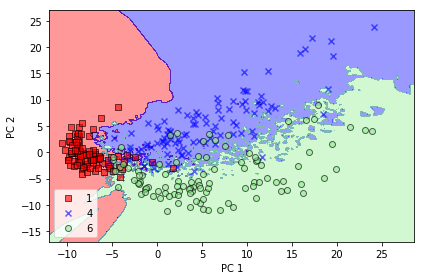

In [79]:
pca = PCA(n_components=2)
x_train_pca = pca.fit_transform(x_train_scaled)
x_test_pca = pca.transform(x_test_scaled)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_pca, y_train)

plot_decision_regions(x_test_pca, y_test, classifier=knn, plot_boundary=True)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('./figures/pca3.png', dpi=300)
plt.show()